# Work Overtime

## Import Data and Library

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [19]:
df_2020 = pd.read_csv('./dataset/survey_results_public_2020.csv')

schema_2020 = pd.read_csv('./dataset/survey_results_schema_2020.csv')

## Business Understanding

Work overtime becomes a common issue happened in the professional world, espescially tech field. In this topic, I want to understand what roles, average working hours, and jobs satisfaction of the overtime workers. The questions that I am trying to answer are:

1. Who works overtime the most?
2. What is the average working hours of the overtime workers?
3. How working overtime related to job satisfaction?

The question from the survey that is relevant is as follows:

In [20]:
schema_2020['QuestionText'][schema_2020['Column'] == 'NEWOvertime'].values[0]

'How often do you work overtime or beyond the formal time expectation of your job?'

## Data Understanding

Now let's see the count of different values we have for each columns we want to use.

In [21]:
df_2020['NEWOvertime'].value_counts()

Sometimes: 1-2 days per month but less than weekly          11547
Often: 1-2 days per week or more                            11027
Occasionally: 1-2 days per quarter but less than monthly     9468
Rarely: 1-2 days per year or less                            6471
Never                                                        4718
Name: NEWOvertime, dtype: int64

In [22]:
df_2020['DevType'].value_counts()

Developer, full-stack                                                                                                                                                                                                                                                                                                                               4424
Developer, back-end                                                                                                                                                                                                                                                                                                                                 3086
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                                                                                                                                                                                        

It seems like there's a lot of developers who has multiple roles. I will need to separate the roles before we go to the analysis. The different roles will be counted separately.

In [23]:
df_2020['WorkWeekHrs'].value_counts()

40.000000     19292
45.000000      3787
50.000000      2747
35.000000      2000
38.000000      1352
              ...  
50.111111         1
69.000000         1
34.500000         1
125.000000        1
22.500000         1
Name: WorkWeekHrs, Length: 157, dtype: int64

In [24]:
df_2020['JobSat'].value_counts()

Very satisfied                        14611
Slightly satisfied                    13930
Slightly dissatisfied                  7124
Neither satisfied nor dissatisfied     5783
Very dissatisfied                      3746
Name: JobSat, dtype: int64

The value for Job Satisfaction need to be converted to numeric so we can measure it better. The value will be mapped to number 1-5.

## Data Preparation and Analysis

Now let's start to answer questions we have listed before. But before we go into questions, we need to check missing values of our main metric, the 'NEWOvertime'.

In [25]:
df_2020['NEWOvertime'].isnull().mean()

0.32934642652146257

Around 33% of respondents didn't answer the Overtime question. For this analysis, we are ignoring the missing values as it will not contribute to the result.

### Who works overtime the most?

In this section we will see which role admitted to work overtime the most. We will see the combination of these 2 categories to represent working overtime:

1. Often: 1-2 days per week or more
2. Sometimes: 1-2 days per month but less than weekly

The percentage of developer type will be taken to see what role works overtime the most.

In [26]:
often = df_2020[df_2020['NEWOvertime'] == 'Often: 1-2 days per week or more']['DevType']
often = often.str.split(';', expand=True).stack().value_counts()
sometimes = df_2020[df_2020['NEWOvertime'] == 'Sometimes: 1-2 days per month but less than weekly']['DevType']
sometimes = sometimes.str.split(';', expand=True).stack().value_counts()
total = df_2020['DevType'].str.split(';', expand=True).stack().value_counts()

In [31]:
dev_type_overtime = pd.DataFrame(round((often + sometimes) / total * 100,2))
dev_type_overtime.columns = ['Percentage']
dev_type_overtime.sort_values(by='Percentage', ascending=False).head(5)

,Percentage
Senior executive/VP,61.06
Engineering manager,57.97
Product manager,56.23
DevOps specialist,53.71
Scientist,53.26


From the table we can see that for all dev types, 40%-61% of them admitted that they work overtime often or sometimes. Senior executive/VP is the one who works overtime the most with 61.06%, followed by Engineering Manager and Product Manager with 57.97% and 56.23%. We can see that there is a tendency for work overtime to developers who do management work dominantly.

### What is the average working hours of the overtime workers?

In this section we will see the average working hours for every overtime status.

Text(0.5, 0, 'Hours/Week')

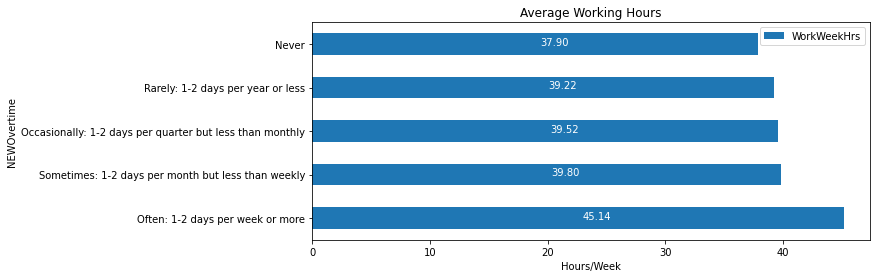

In [28]:
hours = df_2020[['NEWOvertime', 'WorkWeekHrs']]
hour_overtime = hours.groupby(by='NEWOvertime').mean().sort_values(by='WorkWeekHrs', ascending=False)
ax = hour_overtime.plot(kind='barh', title = 'Average Working Hours', figsize=(10,4))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), ((p.get_x() + p.get_width())/2, p.get_y()), xytext=(5, 10), textcoords='offset points',
    color='white')
plt.xlabel("Hours/Week")

From the graph we can see that developers who often work overtime work averagely 45.14 hours in a week, differs largely from those who sometimes work overtime with 5.34 hours difference. If we assume a normal work hours is 40 hours a week, then we can say that developers who often work overtime have 5.14 hours more working hours averagely.

### How overtime work related to job satisfaction?

In this section we will see how overtime work affects job satisfaction. As mentioned in Data Preparation section, we need to convert Job Satisfaction value to numeric.

In [29]:
df_2020 = df_2020.replace({"JobSat": {"Very satisfied": 5, 
                                      "Slightly satisfied": 4, 
                                      "Neither satisfied nor dissatisfied": 3, 
                                      "Slightly dissatisfied": 2, 
                                      "Very dissatisfied": 1}})

job_sat_overtime = df_2020.groupby(['NEWOvertime']).mean()['JobSat'].sort_values().reset_index()
job_sat_overtime.set_index('NEWOvertime', inplace=True)
job_sat_overtime

,JobSat
NEWOvertime,
Never,3.526439
Often: 1-2 days per week or more,3.582901
Rarely: 1-2 days per year or less,3.611973
Occasionally: 1-2 days per quarter but less than monthly,3.677672
Sometimes: 1-2 days per month but less than weekly,3.697527


Text(0.5, 0, 'Job Satisfaction Difference to Average')

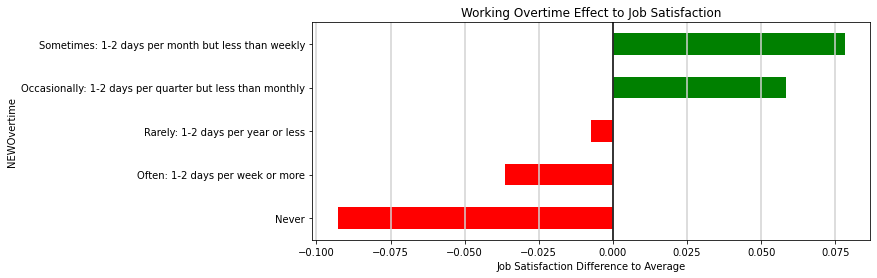

In [32]:
job_sat_overtime['JobSat'] = job_sat_overtime['JobSat'] - job_sat_overtime['JobSat'].mean()
job_sat_overtime['Positive'] = job_sat_overtime['JobSat'] > 0
job_sat_overtime['JobSat'].plot(kind='barh', title='Working Overtime Effect to Job Satisfaction', figsize=(10,4),
                                color=job_sat_overtime.Positive.map({True: 'g', False: 'r'}))

for i in np.arange(-0.1,0.1,0.025):
    plt.axvline(x=i, color='lightgrey')
plt.axvline(x=0, color='black')
plt.xlabel("Job Satisfaction Difference to Average")

From the graph we can see that developers who are never work overtime has the worst job satisfaction, followed by those who often work overtime. Developers who sometimes and occasionally work overtime showed highest job satisfaction.

## Results

To sum up, the analysis results for the Work Overtime topic are as follows:

1. There is a tendency for work overtime to developers who **do management work dominantly**.
2. Developers who often work overtime have **5.14 hours more working hours than normal working hours in a week averagely**.
3. Developers who work overtime in **lesser frequency are highly satisfied with their job**.